# Embedding TSNE

One way to look into how the model is representing genomic k-mers is to run TSNE clustering on the learned embeddings to see how they cluster

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx

In [3]:
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn import manifold, datasets
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import squareform
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.ticker import NullFormatter
import PIL

In [4]:
sys.path.append("..")
from utils import *

In [5]:
def get_emb(path, model, vocab):
    model_path = path/'models'/model
    model = torch.load(model_path, map_location='cpu')
    embedding = model['model']['0.encoder.weight']
    
    vocab = np.load(path/vocab)
    
    return (embedding, vocab)

In [6]:
def tsne_data(embedding, vocab, trunc=3):
    emb_tsne = manifold.TSNE(n_components=2, perplexity=15).fit_transform(embedding.numpy())
    emb_df = pd.DataFrame(emb_tsne, columns=['x','y'])
    emb_df['kmer'] = vocab
    emb_df['kmer_trunc'] = emb_df.kmer.map(lambda x: x[:trunc])
    
    return emb_df

#### Model 1

This embedding comes from the bacterial ensemble model with k-mer length 5 and stride 2 between k-mers. Points are colored based on the first 3 bases of the k-mer.

In [7]:
bact_emb, bact_voc = get_emb(Path('F:/genome/bacterial genomes/'), 'b2.pth', 'bact_vocab.npy')
bact_df = tsne_data(bact_emb, bact_voc)

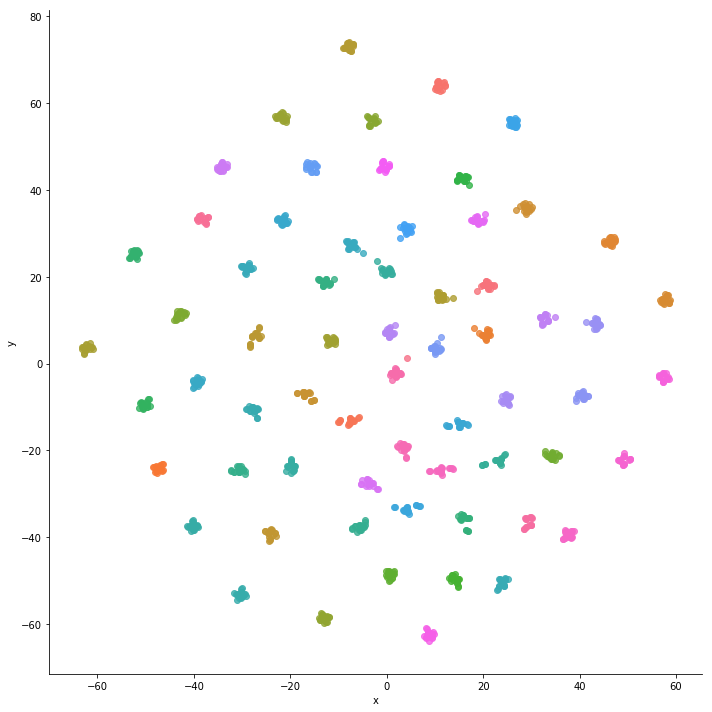

In [8]:
g = sns.lmplot('x', 'y', data=bact_df, hue='kmer_trunc', fit_reg=False, legend=False, height=10)

#### Model 2

This embedding comes from the human genome model with k-mer length 5 and stride 2 between k-mers. Interesting to note how compared to the embedding of the bacterial model, the clusters below are much more spherical.

In [9]:
human_emb, human_voc = get_emb(Path('F:/genome/human/'), 'human_genome_full4.pth', 'human_vocab_5mer.npy')
human_df = tsne_data(human_emb, human_voc)

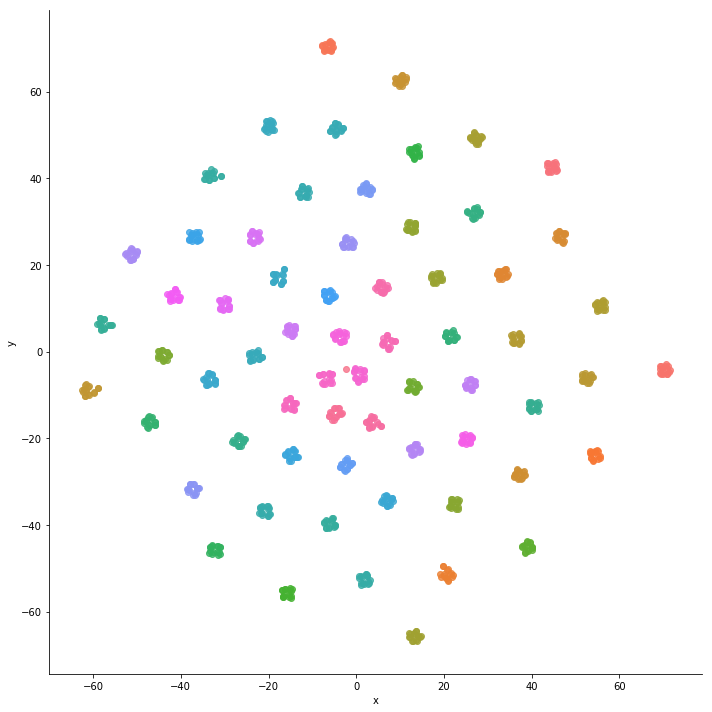

In [10]:
g = sns.lmplot('x', 'y', data=human_df, hue='kmer_trunc', fit_reg=False, legend=False, height=10)

#### Model 3

This embedding comes from the human genome model with k-mer length 3 and stride 1 between k-mers. Points are colored based on the first two bases of each k-mer.

In [11]:
human_emb3, human_voc3 = get_emb(Path('F:/genome/human/'), 'human_3m1s2.pth', 'human_vocab_3m1s.npy')
human_df3 = tsne_data(human_emb3, human_voc3, trunc=2)

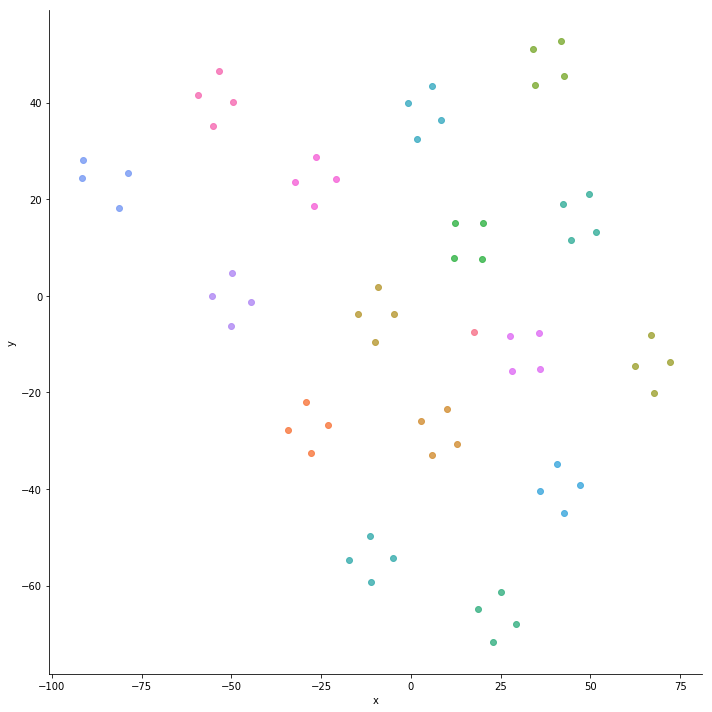

In [12]:
g = sns.lmplot('x', 'y', data=human_df3, hue='kmer_trunc', fit_reg=False, legend=False, height=10)

#### Baseline 1

Embeddings are not typically used for representing genomic sequences. One hot encodings for bases or k-mers are more common. Below is an example of clustering one hot encoded vectors for a k-mer length of 5. The one hot vectors appear to form tight clusters, but if you examine the colors in each cluster you will notice the k-mers cluster seemingly at random.

In [13]:
dummy_emb = torch.eye(len(bact_voc))
one_hot_df = tsne_data(dummy_emb, bact_voc)

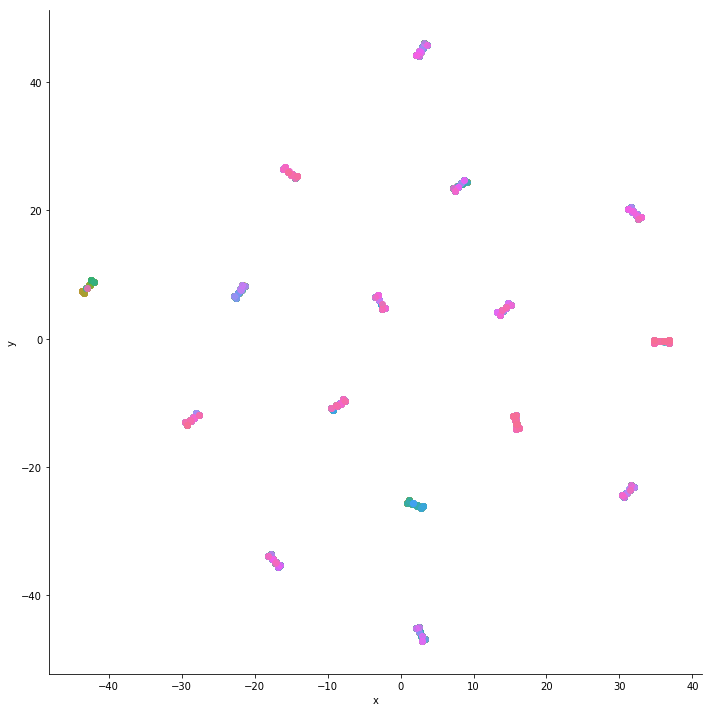

In [14]:
g = sns.lmplot('x', 'y', data=one_hot_df, hue='kmer_trunc', fit_reg=False, legend=False, height=10)

#### Baseline 2

This is clustering of one hot encoded vectors representing k-mers of length 3. Here it is easier to see how the vectors don't encode any relationships between k-mers. This is expected, as all one hot encoded vectors are mutually orthagonal. 

In [15]:
dummy_emb2 = torch.eye(len(human_voc3))
one_hot_df2 = tsne_data(dummy_emb2, human_voc3, trunc=2)

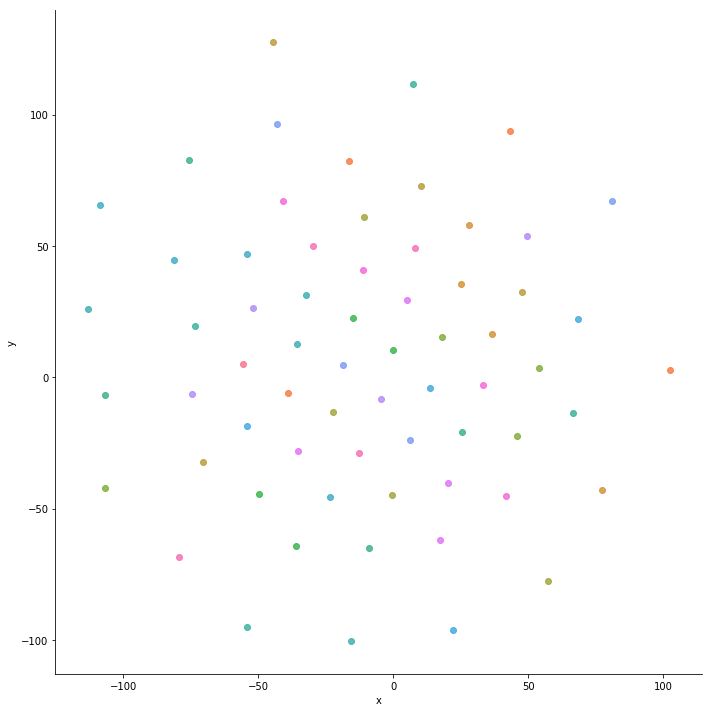

In [16]:
g = sns.lmplot('x', 'y', data=one_hot_df2, hue='kmer_trunc', fit_reg=False, legend=False, height=10)